# COMP 767 Reinforcement Learning 

## Assignment 2

### Rahul Patel 260904634, Xiangyi Zhang 260906083

### Question 1.a

In this task, you will compare the performance of SARSA, expected SARSA and Q-learning
on the Taxi domain from the Gym environment suite:

https://gym.openai.com/envs/Taxi-v2/

Use a tabular representation of the state space, and ensure that the starting and end location
of the passenger are random. Exploration should be softmax (Boltzmann). You will need
to run the following protocol. You will do 10 independent runs. Each run consists of 100
segments, in each segment there are 10 episodes of training, followed by 1 episode in which
you simply run the optimal policy so far (i.e. you pick actions greedily based on the current
value estimates). Pick 3 settings of the temperature parameter used in the exploration and 3
settings of the learning rate. You need to plot:

- One u-shaped graph that shows the effect of the parameters on the final training performance, expressed as the return of the agent (averaged over the last 10 training episodes
and the 10 runs); note that this will typically end up as an upside-down u.
- One u-shaped graph that shows the effect of the parameters on the final testing performance, expressed as the return of the agent (during the final testing episode, averaged
over the 10 runs)
- Learning curves (mean and standard deviation computed based on the 10 runs) for what
you pick as the best parameter setting for each algorithm

Write a small report that describes your experiment, your choices of parameters, and the
conclusions you draw from the graphs

### Temporal Difference (TD) Learning

TD learning is a nice way of combining Dynamic Programming (DP) and Monte Carlo (MC) methods. DP methods purely bootstrap whereas MC methods takes samples. TD method, on the other hand, does both bootstrapping and sampling. We say that TD methods bootstrap as they use value estimates of other states to calculate the value of the current state. Also, TD methods only consider a sample next state over the set of all possible next states. Thus, in some sense TD combines the best of both worlds.

For all the experiments we fix the value of $\gamma$ to be 0.9 and the average rewards are undiscounted total rewards per episode.

In [0]:
# Necessary updates
import gym
import glob
import os
import itertools
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from time import time
from google.colab import files

np.random.seed(7)

# Create the env
env = gym.make("Taxi-v2")

# Experiment parameters
RUNS = 10
SEGMENTS = 100
TRAIN_EPS = 10
ACTIONS = np.arange(env.action_space.n)
ALGOS = ["sarsa", "q_learning", "expected_sarsa"]

In [0]:
# Utility functions

def softmax(x, temp):
    """Compute softmax values for each sets of scores in x.

    Parameters
    ----------
    x : 1D array
        Vector

    temp: float
        Temperature to be used to calculate the softmax

    Returns
    -------
        The softmax values of input vector x for the given temperature
    """
    e_x = np.exp((x - np.max(x))/temp)
    return e_x / e_x.sum()
  
def plot_average_reward_stats(avg_train, avg_test, algorithm="expected_sarsa"):
    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(11, 4))
    # Set the ticks and ticklabels for all axes
    plt.setp(ax, xticks=np.arange(len(ALPHA)),
             xticklabels=[str(alpha) for alpha in ALPHA])

    # Plot train
    for temp_idx, temp in enumerate(TEMP):
        ax[0].plot(avg_train[temp_idx], label="temp-" +
                   str(temp), linestyle='--', marker='o')
    ax[0].set_title("Train "+str(algorithm))
    ax[0].legend()
    # Plot test
    for temp_idx, temp in enumerate(TEMP):
        ax[1].plot(avg_test[temp_idx], label="temp-" +
                   str(temp), linestyle='--', marker='o')
    ax[1].set_title("Test "+str(algorithm))
    ax[1].legend()

    for axis in ax.flat:
        axis.set(xlabel='Alpha', ylabel='Average reward')

    # plt.show()
    plt.subplots_adjust(wspace=0.5)    
    plt.savefig(algorithm+".jpg")
    plt.show()
    
def plot_training(mean, std_dev, algorithm, temp, alpha, setting):
    print("Plotting best parameters based on {} average total reward".format(setting))
    title = algorithm+" "+"Temp: "+str(temp)+" "+"Alpha: "+str(alpha)
    filename = "_".join([algorithm, str(temp), str(alpha), setting])
    plt.figure()
    plt.title(title)
    plt.plot(mean["train"], label="Train", linestyle='--', marker='o', color='red')
    plt.fill_between(np.arange(SEGMENTS), mean["train"] - std_dev["train"], 
                     mean["train"] + std_dev["train"], color="red", alpha=0.2)
    plt.plot(mean["test"], label="Test", linestyle='--', marker='o', color='green')
    plt.fill_between(np.arange(SEGMENTS), mean["test"] - std_dev["test"], 
                     mean["test"] + std_dev["test"], color="green", alpha=0.2)
    plt.xlabel("Segments")
    plt.ylabel("Average reward")
    plt.legend()
    plt.savefig(filename+".jpg")
    plt.show()


## Expected SARSA Update
We follow the below mentioned update rule while while performing expected SARSA updates to the Q action-value table.

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[R_{t+1}+\gamma \textbf{E}[Q(S_{t+1}, A_{t+1})] - Q(s, a) \right]$$

where,
$S_t=$ current state, $A_t=$ current action, $S_{t+1}=$ next state, $A_{t+1}=$ next action, $R_{t+1}=$ reward obtained during state transition, $Q=$ table storing action values.

In [0]:
def expected_sarsa_update(Q, temp, alpha, gamma=0.9):
    """
    Update Q table using expected sarsa for an episode

    Parameters
    ----------
    Q : 2D array
        Q table containing the state, action values
    temp : float
        Temperature for the softmax exploration
    alpha : float
        Learning rate
    gamma : float
        Discount factor

    Returns
    -------
    Q : 2D array
        The updated Q table after the episode
    t : int
        The duration for which the timesteps ran
    sum(rewards) : int
        Total reward accumulated in the episode
    """
    rewards = []
    state = env.reset()

    for t in itertools.count():
        # Sample action based on softmax
        probs = softmax(Q[state], temp)
        action = np.random.choice(ACTIONS, p=probs)
        # Perform action and move to next state and get a reward in the process
        next_state, reward, done, _ = env.step(action)
        # Update rewards
        rewards.append(reward)
        # Form the TD target
        next_action_probs = softmax(Q[next_state], temp)
        # print("Gamma", gamma, "Sum", np.sum(next_action_probs * Q[next_state]))
        td_target = reward + gamma * np.sum(next_action_probs * Q[next_state])
        # Calculate TD error
        td_delta = td_target - Q[state][action]
        # Update the Q value
        Q[state][action] += alpha * td_delta

        if done:
            break

        state = next_state

    return Q, t, np.sum(rewards)

## SARSA Update
We follow the below mentioned update rule while while performing SARSA updates to the Q action-value table.

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[R_{t+1}+\gamma Q(S_{t+1}, A_{t+1}) - Q(S_t, A_t) \right]$$

where,
$S_t=$ current state, $A_t=$ current action, $S_{t+1}=$ next state, $A_{t+1}=$ next action, $R_{t+1}=$ reward obtained during state transition, $Q=$ table storing action values.

In [0]:
def sarsa_update(Q, temp, alpha, gamma=0.9):
    """
    Update Q table using sarsa for an episode

    Parameters
    ----------
    Q : 2D array
        Q table containing the state, action values
    temp : float
        Temperature for the softmax exploration
    alpha : float
        Learning rate
    gamma : float
        Discount factor

    Returns
    -------
    Q : 2D array
        The updated Q table after the episode
    t : int
        The duration for which the timesteps ran
    sum(rewards) : int
        Total reward accumulated in the episode
    """
    rewards = []
    state = env.reset()

    for t in itertools.count():
        # Sample action based on softmax
        probs = softmax(Q[state], temp)
        action = np.random.choice(ACTIONS, p=probs)
        # Perform action and move to next state and get a reward in the process
        next_state, reward, done, _ = env.step(action)
        # Update rewards
        rewards.append(reward)
        # Form the TD target
        probs = softmax(Q[next_state], temp)
        next_action = np.random.choice(ACTIONS, p=probs)
        td_target = reward + gamma * Q[next_state][next_action]
        # Calculate TD error
        td_delta = td_target - Q[state][action]
        # Update the Q value
        Q[state][action] += alpha * td_delta

        if done:
            break

        state = next_state

    return Q, t, np.sum(rewards)


## Q learning

We follow the below mentioned update rule while performing Q-learning updates to the Q action-value table.

$$Q(S_t, A_t) \leftarrow Q(S_t, A_t) + \alpha \left[R_{t+1}+ \text{max}_{a} (S_{t+1}, a) - Q(S_t, A_{t}) \right]$$


$S_t=$ current state, $A_t=$ current action, $S_{t+1}=$ next state, $A_{t+1}=$ next action, $R_{t+1}=$ reward obtained during state transition, $Q=$ table storing action values.

In [0]:
def q_learning_update(Q, temp, alpha, gamma=0.9):
    """
    Update Q table using Q learning for an episode

    Parameters
    ----------
    Q : 2D array
        Q table containing the state, action values
    temp : float
        Temperature for the softmax exploration
    alpha : float
        Learning rate
    gamma : float
        Discount factor

    Returns
    -------
    Q : 2D array
        The updated Q table after the episode
    t : int
        The duration for which the timesteps ran
    sum(rewards) : int
        Total reward accumulated in the episode
    """
    rewards = []
    state = env.reset()

    for t in itertools.count():
        # Sample action based on softmax
        probs = softmax(Q[state], temp)
        action = np.random.choice(ACTIONS, p=probs)
        # Perform action and move to next state and get a reward in the process
        next_state, reward, done, _ = env.step(action)
        # Update rewards
        rewards.append(reward)
        # Form the TD target
        td_target = reward + gamma * np.max(Q[next_state])
        # Calculate TD error
        td_delta = td_target - Q[state][action]
        # Update the Q value
        Q[state][action] += alpha * td_delta

        if done:
            break

        state = next_state

    return Q, t, np.sum(rewards)


In [0]:
def act_greedy(Q):
    """
    Behave greedily based on the Q value estimates and calculate the total 
    reward over an episode

    Parameters
    ----------
    Q : 2D array
        Q table containing the state, action values

    Returns
    -------
    t : int
        Number of timesteps for an episode
    sum(rewards) : int
        Total reward accumulated over the episode by acting greedily based on 
        the input Q table
    """
    rewards = []
    state = env.reset()

    for t in itertools.count():
        action = np.argmax(Q[state])
        next_state, reward, done, _ = env.step(action)
        rewards.append(reward)

        if done:
            break

        state = next_state

    return t, np.sum(rewards)


In [0]:
def perform_experiment(temp, alpha, algorithm):
    """
    Perform the experiment for a given hyperparameters and algorithm
    
    Parameters
    ----------
    temp : float
        Temperature used in softmax exploration
    alpha : float
        Learning rate
    algorithm : string
        Name of the algorithm for which we are conduction the experiement
        
    Returns
    -------
    train_reward : 2D array
        Total reward obtained in the last episode of each segment 
        for a given run during training
    train_step : 2D array
        Timesteps taken in the last episode of each segment for a 
        given run during training
    test_reward : 2D array
        Total reward obtained in the test episode of each segment 
        for a given run
    test_step : 2D array
        Timesteps taken in the test episode of each segment for a 
        given run        
    """
    train_reward = np.zeros((RUNS, SEGMENTS))
    test_reward = np.zeros((RUNS, SEGMENTS))
    train_step = np.zeros((RUNS, SEGMENTS))
    test_step = np.zeros((RUNS, SEGMENTS))

    for run in range(RUNS):
        Q = np.zeros((env.observation_space.n, env.action_space.n))
        for segment in range(SEGMENTS):
            # Run train episode
            for train_eps in range(TRAIN_EPS):
                if algorithm == "expected_sarsa":
                    Q, timesteps, avg_reward = expected_sarsa_update(
                        Q, temp, alpha)
                elif algorithm == "sarsa":
                    Q, timesteps, avg_reward = sarsa_update(
                        Q, temp, alpha)
                elif algorithm == "q_learning":
                    Q, timesteps, avg_reward = q_learning_update(
                        Q, temp, alpha)
                else:
                    raise ValueError(
                        "Provide a valid value for <algorithm> parameter")
            train_reward[run][segment] = avg_reward
            train_step[run][segment] = timesteps

            # Run test episode
            timesteps, avg_reward = act_greedy(Q)
            test_reward[run][segment] = avg_reward
            test_step[run][segment] = avg_reward            

    return train_reward, train_step, test_reward, test_step


In [0]:
def find_best_stats(data, train_reward, test_reward):
    maximum = np.amax(data)
    [t_idx, a_idx] = np.argwhere(data == maximum)[0]

    mean={}
    mean["train"] = np.average(train_reward[t_idx][a_idx], axis=0)
    mean["test"] = np.average(test_reward[t_idx][a_idx], axis=0)  
    
    std_dev={}
    std_dev["train"] = np.std(train_reward[t_idx][a_idx], axis=0)
    std_dev["test"] = np.std(test_reward[t_idx][a_idx], axis=0)  
    
    return mean, std_dev, t_idx, a_idx, maximum

We evaluate the result

In [0]:
def get_stats(algorithm="expected_sarsa"):
    stats = {}
    start = time()
    print("############## {} ###############".format(algorithm))
    train_reward = np.zeros((len(TEMP), len(ALPHA), RUNS, SEGMENTS))
    train_step = np.zeros((len(TEMP), len(ALPHA), RUNS, SEGMENTS))
    test_reward = np.zeros((len(TEMP), len(ALPHA), RUNS, SEGMENTS))
    test_step = np.zeros((len(TEMP), len(ALPHA), RUNS, SEGMENTS))

    avg_train = np.zeros((len(TEMP), len(ALPHA)))
    avg_test = np.zeros((len(TEMP), len(ALPHA)))

    for t_idx, temp in enumerate(TEMP):
        for a_idx, alpha in enumerate(ALPHA):
            print("Performing experiment for temperature {} alpha {}".format(temp, alpha))
            _train_reward, _train_step, _test_reward, _test_step = perform_experiment(
                temp, alpha, algorithm)

            train_reward[t_idx][a_idx] = _train_reward
            train_step[t_idx][a_idx] = _train_step
            test_reward[t_idx][a_idx] = _test_reward
            test_step[t_idx][a_idx] = _test_step

            # print(avg_train[t_idx][a_idx], avg_test[t_idx][a_idx])
            avg_train[t_idx][a_idx] = np.average(
                [_train_reward[run][-1] for run in range(RUNS)])
            avg_test[t_idx][a_idx] = np.average(
                [_test_reward[run][-1] for run in range(RUNS)])
                
    end = time()
    print("Took {:.2f} seconds to finish the experiment".format(end-start))
    stats["avg_train"] = avg_train
    stats["avg_test"] = avg_test
    
    mean, std_dev, t_idx, a_idx, maximum = find_best_stats(avg_train, 
                                                           train_reward, test_reward)
    print("-------------- Best parameters based on Train -----------------")
    print("* Best parameters, Temperature: {},  Alpha: {}".format(TEMP[t_idx], 
                                                                  ALPHA[a_idx]))
    print("* Best average reward: {}".format(maximum))
    stats["train_mean"] = mean
    stats["train_std_dev"] = std_dev
    stats["train_t_idx"] = t_idx
    stats["train_a_idx"] = a_idx        
    
    mean, std_dev, t_idx, a_idx, maximum = find_best_stats(avg_test, 
                                                           train_reward, test_reward)        
    print("-------------- Best parameters based on Test -----------------")        
    print("* Best parameters, Temperature: {},  Alpha: {}".format(TEMP[t_idx], 
                                                                  ALPHA[a_idx]))
    print("* Best average reward: {}".format(maximum))
    stats["test_mean"] = mean
    stats["test_std_dev"] = std_dev
    stats["test_t_idx"] = t_idx
    stats["test_a_idx"] = a_idx    
    return stats

# Hyperparameter Tuning

## Temperature
We first of all do a hyper-parameter search. We fix the $\tau$ to be **[0.1, 1, 10]**. Let us see the expression of softmax exploration with temperature. It gives us the probability of selecting an action $a$ when in state $s$.

$$ p(a|s) = \frac{e^{Q(s, a)/\tau}}{\sum_a e^{Q(s, a)/\tau}}$$

We can clearly see that when $\tau$ is 1, we do normal softmax exploration. Suppose we set the value of temperature to infinity we will get uniform exploration with equal probability of each action being selected. Thus setting the value of temperature high - 10 in this case - leads to random exploratory policy. Also, when the temperature parameter is made less than one, we overweight the importance of the action with the maximum probability. Thus setting the value of temperature low - 0.1 in this case - leads to an epsilon-greedy policy.

## Alpha
Then we change the parameters by an order of magnitude to see which range is the most interesting one. We vary $\alpha$ from 0.0001 to 1, by increasing it by a factor of 10 i.e. **[0.0001, 0.001, 0.01, 0.1, 1]**

Finding new statistics
############## sarsa ###############
Performing experiment for temperature 0.1 alpha 0.0001
Performing experiment for temperature 0.1 alpha 0.001
Performing experiment for temperature 0.1 alpha 0.01
Performing experiment for temperature 0.1 alpha 0.1
Performing experiment for temperature 0.1 alpha 1
Performing experiment for temperature 1 alpha 0.0001
Performing experiment for temperature 1 alpha 0.001
Performing experiment for temperature 1 alpha 0.01
Performing experiment for temperature 1 alpha 0.1
Performing experiment for temperature 1 alpha 1
Performing experiment for temperature 10 alpha 0.0001
Performing experiment for temperature 10 alpha 0.001
Performing experiment for temperature 10 alpha 0.01
Performing experiment for temperature 10 alpha 0.1
Performing experiment for temperature 10 alpha 1
Took 2153.51 seconds to finish the experiment
-------------- Best parameters based on Train -----------------
* Best parameters, Temperature: 0.1,  Alpha: 1
* Best

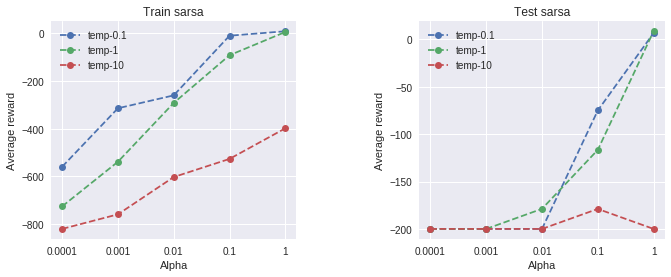

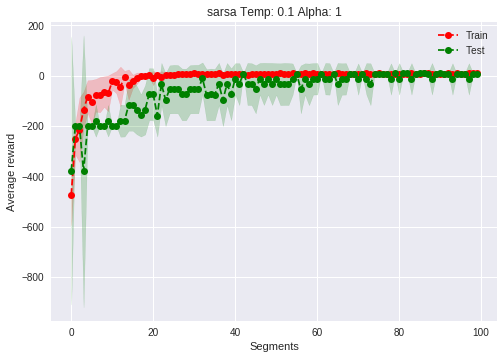

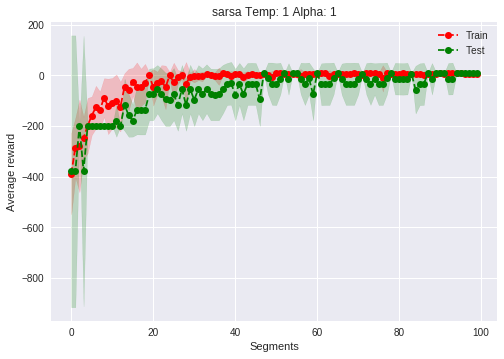

Finding new statistics
############## q_learning ###############
Performing experiment for temperature 0.1 alpha 0.0001
Performing experiment for temperature 0.1 alpha 0.001
Performing experiment for temperature 0.1 alpha 0.01
Performing experiment for temperature 0.1 alpha 0.1
Performing experiment for temperature 0.1 alpha 1
Performing experiment for temperature 1 alpha 0.0001
Performing experiment for temperature 1 alpha 0.001
Performing experiment for temperature 1 alpha 0.01
Performing experiment for temperature 1 alpha 0.1
Performing experiment for temperature 1 alpha 1
Performing experiment for temperature 10 alpha 0.0001
Performing experiment for temperature 10 alpha 0.001
Performing experiment for temperature 10 alpha 0.01
Performing experiment for temperature 10 alpha 0.1
Performing experiment for temperature 10 alpha 1
Took 1407.83 seconds to finish the experiment
-------------- Best parameters based on Train -----------------
* Best parameters, Temperature: 0.1,  Alpha: 1
*

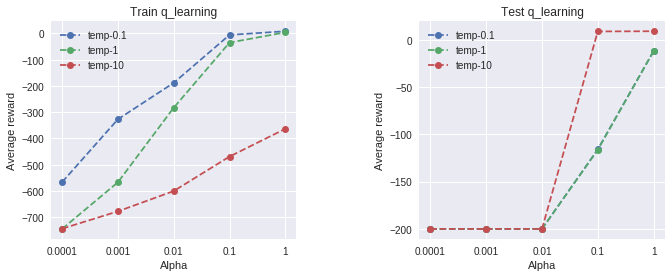

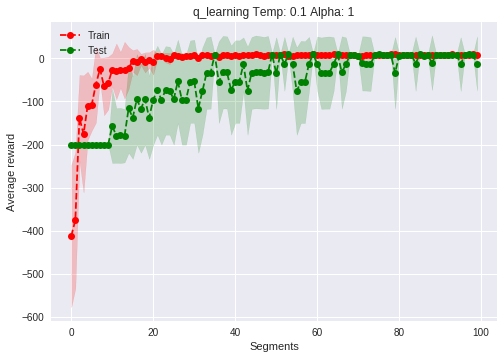

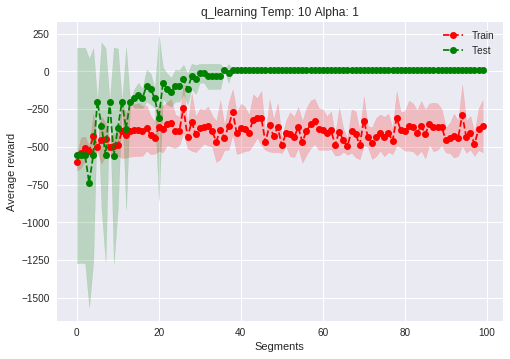

Finding new statistics
############## expected_sarsa ###############
Performing experiment for temperature 0.1 alpha 0.0001
Performing experiment for temperature 0.1 alpha 0.001
Performing experiment for temperature 0.1 alpha 0.01
Performing experiment for temperature 0.1 alpha 0.1
Performing experiment for temperature 0.1 alpha 1
Performing experiment for temperature 1 alpha 0.0001
Performing experiment for temperature 1 alpha 0.001
Performing experiment for temperature 1 alpha 0.01
Performing experiment for temperature 1 alpha 0.1
Performing experiment for temperature 1 alpha 1
Performing experiment for temperature 10 alpha 0.0001
Performing experiment for temperature 10 alpha 0.001
Performing experiment for temperature 10 alpha 0.01
Performing experiment for temperature 10 alpha 0.1
Performing experiment for temperature 10 alpha 1
Took 1744.80 seconds to finish the experiment
-------------- Best parameters based on Train -----------------
* Best parameters, Temperature: 0.1,  Alpha:

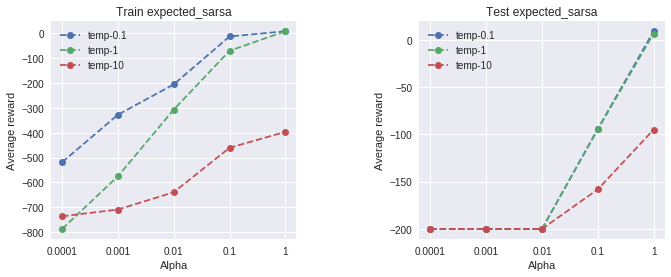

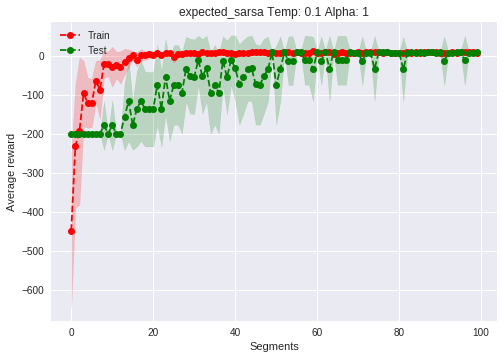

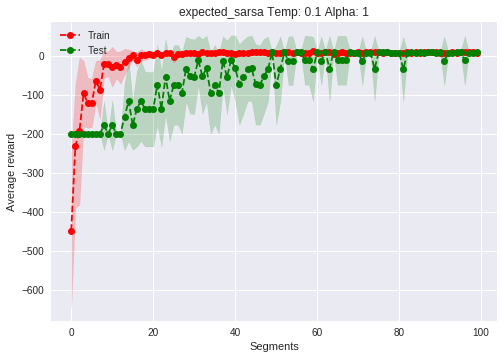

In [11]:
# Set the hyper parameters
TEMP = [0.1, 1, 10]
ALPHA = [0.0001, 0.001, 0.01, 0.1, 1]

for algo in ALGOS:
    filename = algo+"_"+str(ALPHA[0])+"_stats.npy"
    # Check if the stats already exists
    if filename in glob.glob("*.npy"):
        print("Loading old statistics")
        stats = np.load(filename).item()
    else:
        print("Finding new statistics")
        stats = get_stats(algorithm=algo)
        np.save(filename, stats)
    
    plot_average_reward_stats(stats["avg_train"], stats["avg_test"], algorithm=algo)    
        
    # Plot learning curves based on best train setting
    plot_training(stats["train_mean"], stats["train_std_dev"], algo, 
                  TEMP[stats["train_t_idx"]], ALPHA[stats["train_a_idx"]], "train")    
    
    # Plot learning curves based on best test setting
    plot_training(stats["test_mean"], stats["test_std_dev"], algo, 
                  TEMP[stats["test_t_idx"]], ALPHA[stats["test_a_idx"]], "test")    


## Fine tuning the range of $\alpha$
As we see, average reward almost increases linearly w.r.t. $\alpha$ till 0.1. We observe almost plateau like surface between 0.1 to 1. Hence the interesting range of $\alpha$ to further investigate would be around this. Thus, we repreat the above experiements, but with new $\alpha$ values **[0.001, 0.4, 0.8, 1, 2]**

Finding new statistics
############## sarsa ###############
Performing experiment for temperature 0.1 alpha 0.001
Performing experiment for temperature 0.1 alpha 0.4
Performing experiment for temperature 0.1 alpha 0.8
Performing experiment for temperature 0.1 alpha 1
Performing experiment for temperature 0.1 alpha 2
Performing experiment for temperature 1 alpha 0.001
Performing experiment for temperature 1 alpha 0.4
Performing experiment for temperature 1 alpha 0.8
Performing experiment for temperature 1 alpha 1
Performing experiment for temperature 1 alpha 2
Performing experiment for temperature 10 alpha 0.001
Performing experiment for temperature 10 alpha 0.4
Performing experiment for temperature 10 alpha 0.8
Performing experiment for temperature 10 alpha 1
Performing experiment for temperature 10 alpha 2
Took 1729.21 seconds to finish the experiment
-------------- Best parameters based on Train -----------------
* Best parameters, Temperature: 1,  Alpha: 1
* Best average reward: 9.9

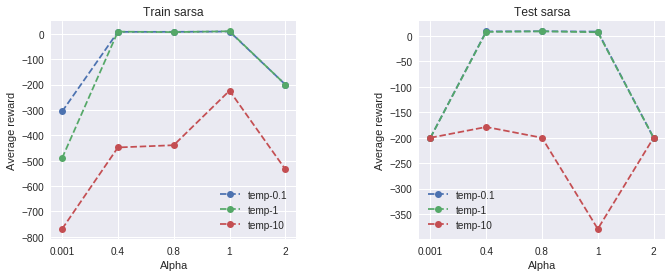

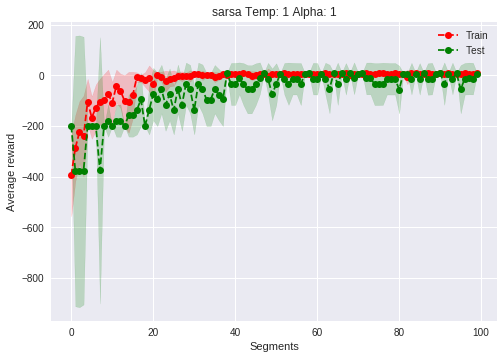

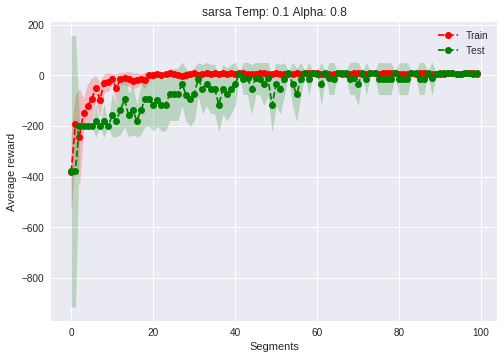

Finding new statistics
############## q_learning ###############
Performing experiment for temperature 0.1 alpha 0.001
Performing experiment for temperature 0.1 alpha 0.4
Performing experiment for temperature 0.1 alpha 0.8
Performing experiment for temperature 0.1 alpha 1
Performing experiment for temperature 0.1 alpha 2
Performing experiment for temperature 1 alpha 0.001
Performing experiment for temperature 1 alpha 0.4
Performing experiment for temperature 1 alpha 0.8
Performing experiment for temperature 1 alpha 1
Performing experiment for temperature 1 alpha 2
Performing experiment for temperature 10 alpha 0.001
Performing experiment for temperature 10 alpha 0.4
Performing experiment for temperature 10 alpha 0.8
Performing experiment for temperature 10 alpha 1
Performing experiment for temperature 10 alpha 2
Took 1143.80 seconds to finish the experiment
-------------- Best parameters based on Train -----------------
* Best parameters, Temperature: 0.1,  Alpha: 1
* Best average rewa

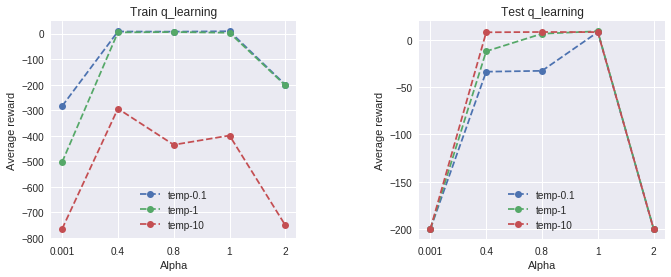

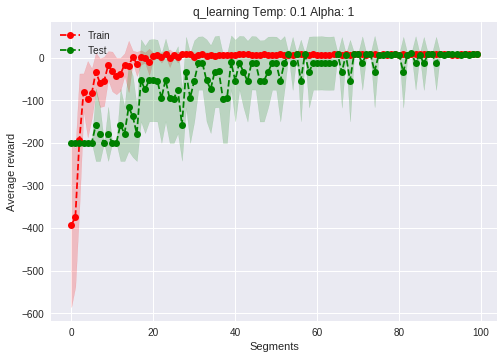

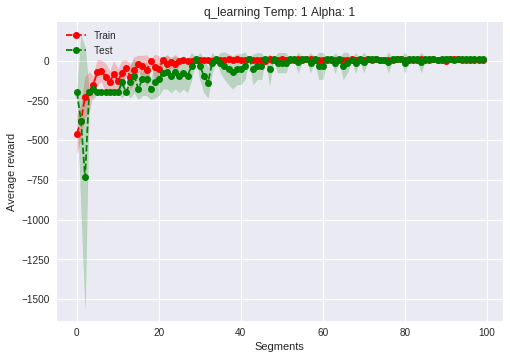

Finding new statistics
############## expected_sarsa ###############
Performing experiment for temperature 0.1 alpha 0.001
Performing experiment for temperature 0.1 alpha 0.4
Performing experiment for temperature 0.1 alpha 0.8
Performing experiment for temperature 0.1 alpha 1
Performing experiment for temperature 0.1 alpha 2
Performing experiment for temperature 1 alpha 0.001
Performing experiment for temperature 1 alpha 0.4
Performing experiment for temperature 1 alpha 0.8
Performing experiment for temperature 1 alpha 1
Performing experiment for temperature 1 alpha 2
Performing experiment for temperature 10 alpha 0.001
Performing experiment for temperature 10 alpha 0.4
Performing experiment for temperature 10 alpha 0.8
Performing experiment for temperature 10 alpha 1
Performing experiment for temperature 10 alpha 2
Took 1383.10 seconds to finish the experiment
-------------- Best parameters based on Train -----------------
* Best parameters, Temperature: 0.1,  Alpha: 0.4
* Best averag

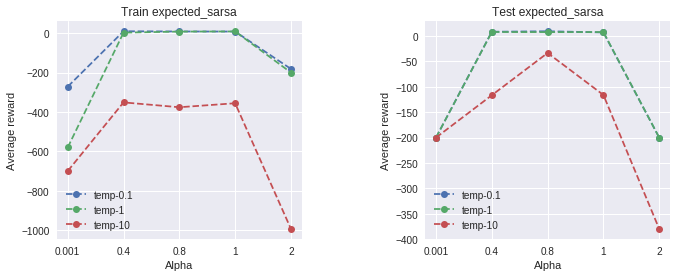

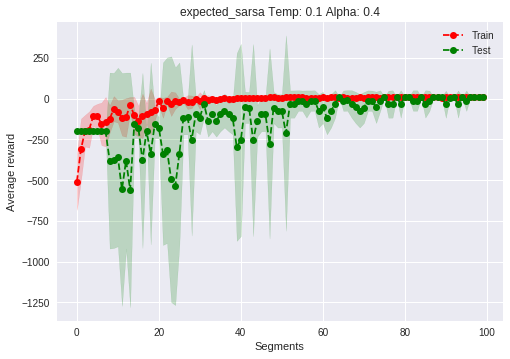

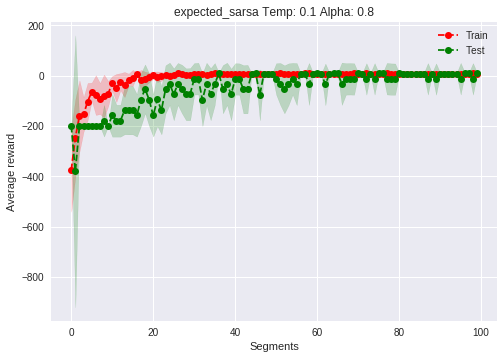

In [12]:
# Set the hyper parameters
TEMP = [0.1, 1, 10]
ALPHA = [0.001, 0.4, 0.8, 1, 2]

for algo in ALGOS:
    filename = algo+"_"+str(ALPHA[0])+"_stats.npy"
    # Check if the stats already exists
    if filename in glob.glob("*.npy"):
        print("Loading old statistics")
        stats = np.load(filename).item()
    else:
        print("Finding new statistics")
        stats = get_stats(algorithm=algo)
        np.save(filename, stats)
    
    plot_average_reward_stats(stats["avg_train"], stats["avg_test"], algorithm=algo)    
        
    # Plot learning curves based on best train setting
    plot_training(stats["train_mean"], stats["train_std_dev"], algo, 
                  TEMP[stats["train_t_idx"]], ALPHA[stats["train_a_idx"]], "train")    
    
    # Plot learning curves based on best test setting
    plot_training(stats["test_mean"], stats["test_std_dev"], algo, 
                  TEMP[stats["test_t_idx"]], ALPHA[stats["test_a_idx"]], "test")    

    

# Results

## Best Paramters based on Train performance

Algorithm | Temperature $\tau$ | Alpha $\alpha$ | Average reward
------------|
**SARSA** | **1** | **1** | **9.9**  
Q-learning | 0.1 | 1 | 9.0  
Expected SARSA | 0.1 | 0.4 | 9.5  

## Best Paramters based on Test performance


Algorithm | Temperature $\tau$ | Alpha $\alpha$ | Average reward
------------|
SARSA | 0.1 | 0.8 | 9.3  
Q-learning | 1 | 1 | 9.2  
**Expected SARSA** | **0.1** | **0.8** | **9.6**  

# Comments

- SARSA performs best during train phase with average reward of 9.9, temperature 1 and alpha 1. The overall order of performance being SARSA > Expected SARSA > Q-learning.
- Expected SARSA performs best during test phase with average reward of 9.6, temperature 0.1 and alpha 0.8. The overall order of performance being Expected SARSA > SARSA > Q-learning.
- We clearly see a U shaped performance of the three algorithms w.r.t. $\alpha$. It indicates that learning rate values must be tuned carefully. Keeping them too high or too low will deteriorate the performance of the algorithm. In this case, setting $\alpha$ between 0.1 to 1 gives better average rewards as compared to the ones lying outside the range.
- As we know, Q-learning is a special case of Expected SARSA, with the policy being used to evaluate expectation being a greedy policy. Thus, when set the temperature parameter to be small i.e. 0.1 we essentially make the softmax exploration policy a greedy policy. Thus we see almost similar trends in the Q-learning and Expected Sarsa with low temperature.
- Q-learning with high temperature performs miserably. However, this exploration helps in exploring the state space well. Thus during testing, the perform improves significantly and is almost equal to the other two techniques. While during testing, because of random exploration it is not able to perform well and accumulate better rewards.
- The results showcased above are subject to change over re-running the experiement. Previously, the maximum reward we were able to obtain was 9 (test case). However, by reconducting the experiement the average reward increased to 9.6 (test case). Thus 10 runs and 100 segments might not be sufficient to reduce the variance in such experiements. 
- Gamma is assumed to be paramter of the problem and not the solution. Thus using a different value of gamma will change the results. Ideally the value of gamma should be choosen based on the problem setting. Essentially you can set the gamma between [0, 1], where setting the gamma small will make your agent short shighted while a high gamma will make the agent far sighted.

